In [1]:
import uproot
import numpy as np
import scipy.stats as sps
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from pylorentz import Momentum4, Position4
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
tree_tt = uproot.open("../MVAFILE_AllHiggs_tt_new.root")["ntuple"]
print('loaded root file')
variables = [
            "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
            "aco_angle_1", 
#             "aco_angle_5", "aco_angle_6", "aco_angle_7", 
            "mva_dm_1","mva_dm_2",
            "tau_decay_mode_1","tau_decay_mode_2",
#             "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
            "pi_E_1", "pi_px_1", "pi_py_1", "pi_pz_1", 
            "pi_E_2", "pi_px_2", "pi_py_2", "pi_pz_2", 
            "pi0_E_1", "pi0_px_1", "pi0_py_1", "pi0_pz_1",
            "pi0_E_2", "pi0_px_2", "pi0_py_2", "pi0_pz_2", 
            "y_1_1", "y_1_2",
            'met', 'metx', 'mety',
        #     'sv_x_1', 'sv_y_1', 'sv_z_1', 'sv_x_2', 'sv_y_2','sv_z_2'
        ]
# variables += ["gen_nu_p_1", "gen_nu_phi_1", "gen_nu_eta_1", #leading neutrino, gen level
#             "gen_nu_p_2", "gen_nu_phi_2", "gen_nu_eta_2" #subleading neutrino, gen level
#              ]
df_tt = tree_tt.pandas.df(variables)
print('loaded df')
# select only rho-rho events
df_rho = df_tt[(df_tt['mva_dm_1']==1) & (df_tt['mva_dm_2']==1) & (df_tt["tau_decay_mode_1"] == 1) & (df_tt["tau_decay_mode_2"] == 1)]
# drop unnecessary labels 
df = df_rho.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)
print('finished rho-rho loading')

In [2]:
df_tt = pd.read_pickle('./df_tt.pkl')
df_rho = df_tt[(df_tt['mva_dm_1']==1) & (df_tt['mva_dm_2']==1) & (df_tt["tau_decay_mode_1"] == 1) & (df_tt["tau_decay_mode_2"] == 1)]
df_reco = df_rho.drop(["mva_dm_1","mva_dm_2","tau_decay_mode_1","tau_decay_mode_2", "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)

In [2]:
df_tt_gen = pd.read_pickle('./df_tt_gen.pkl')
df_rho = df_tt_gen[(df_tt_gen['dm_1']==1) & (df_tt_gen['dm_2']==1)]
df_gen = df_rho.drop(["dm_1","dm_2","wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand"], axis=1).reset_index(drop=True)

In [3]:
def get_products(df_reco):
    pi_1 = Momentum4(df_reco['pi_E_1'], df_reco["pi_px_1"], df_reco["pi_py_1"], df_reco["pi_pz_1"])
    pi_2 = Momentum4(df_reco['pi_E_2'], df_reco["pi_px_2"], df_reco["pi_py_2"], df_reco["pi_pz_2"])
    pi0_1 = Momentum4(df_reco['pi0_E_1'], df_reco["pi0_px_1"], df_reco["pi0_py_1"], df_reco["pi0_pz_1"])
    pi0_2 = Momentum4(df_reco['pi0_E_2'], df_reco["pi0_px_2"], df_reco["pi0_py_2"], df_reco["pi0_pz_2"])
    rho_1 = pi_1 + pi0_1
    rho_2 = pi_2 + pi0_2
    return pi_1, pi_2, pi0_1, pi0_2, rho_1, rho_2

In [4]:
ip_1 = np.c_[df_reco['ip_x_1'], df_reco['ip_y_1'], df_reco['ip_z_1']]
ip_2 = np.c_[df_reco['ip_x_2'], df_reco['ip_y_2'], df_reco['ip_z_2']]

NameError: name 'df_reco' is not defined

## investigating gen SV and p_t_vis

In [5]:
df_gen.keys()

Index(['pi_E_1', 'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_2', 'pi_px_2',
       'pi_py_2', 'pi_pz_2', 'pi0_E_1', 'pi0_px_1', 'pi0_py_1', 'pi0_pz_1',
       'pi0_E_2', 'pi0_px_2', 'pi0_py_2', 'pi0_pz_2', 'metx', 'mety', 'sv_x_1',
       'sv_y_1', 'sv_z_1', 'sv_x_2', 'sv_y_2', 'sv_z_2'],
      dtype='object')

In [6]:
sv_df = df_gen[['sv_x_1', 'sv_y_1', 'sv_z_1', 'sv_x_2', 'sv_y_2', 'sv_z_2']]
pi_1, pi_2, pi0_1, pi0_2, rho_1, rho_2 = get_products(df_gen)
sv_df['p_t_vis_1'] = rho_1.p
sv_df['p_t_vis_2'] = rho_2.p

<ipython-input-6-90836dda2a75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sv_df['p_t_vis_1'] = rho_1.p
<ipython-input-6-90836dda2a75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sv_df['p_t_vis_2'] = rho_2.p


In [7]:
sv_df.head()

,sv_x_1,sv_y_1,sv_z_1,sv_x_2,sv_y_2,sv_z_2,p_t_vis_1,p_t_vis_2
0,0.023583,0.019393,0.005763,-0.581665,-0.513909,0.018126,33.753041,52.583766
1,0.264949,-0.061602,-0.161944,-0.120283,-0.045656,-0.260196,37.600309,127.553300
2,0.238845,0.233997,0.112015,-0.280071,0.057288,0.059971,59.091590,67.625778
3,-0.005463,0.055390,0.092998,0.429833,-1.008276,3.836661,65.426963,145.224950
4,0.066919,0.085073,-0.095757,0.065669,0.054346,0.027046,56.050964,80.801777


In [9]:
from pandas_profiling import ProfileReport
profile = ProfileReport(sv_df, title='Pandas Profiling Report', explorative=True)

C:\Users\Stanley\.conda\envs\msci\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [10]:
profile.to_widgets()

In [11]:
profile.to_file("sv_df.html")

In [12]:
# p_t_vis_1 = rho_1.p
# p_t_vis_2 = rho_2.p
# sv_x_1, sv_y_1, sv_z_1 = sv_df['sv_x_1'], sv_df['sv_y_1'], sv_df['sv_z_1'] 
# sv_x_2, sv_y_2, sv_z_2 = sv_df['sv_x_2'], sv_df['sv_y_2'], sv_df['sv_z_2']

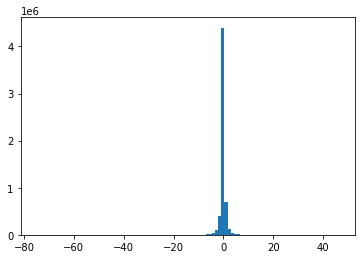

In [8]:
plt.figure()
plt.hist(sv_df['sv_z_1'], bins=100)
plt.show()

In [9]:
%matplotlib notebook
def three_d_scatterplot(p_t_vis, sv_x, sv_y, sv_z, samples=10000):
    idx = np.random.choice(np.arange(len(p_t_vis)), samples, replace=False)
    p_t_vis = p_t_vis[idx]
    sv_x = sv_x[idx]
    sv_y = sv_y[idx]
    sv_z = sv_z[idx]
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(sv_x, sv_y, sv_z, c=p_t_vis, cmap=plt.hot())
    fig.colorbar(img)
    plt.show()


Fit params: 0.006096002132235139, 0.07016783196311625
Diag of cov: 2.1472147450381446e-09 , 9.80534420058444e-06


<IPython.core.display.Javascript object>


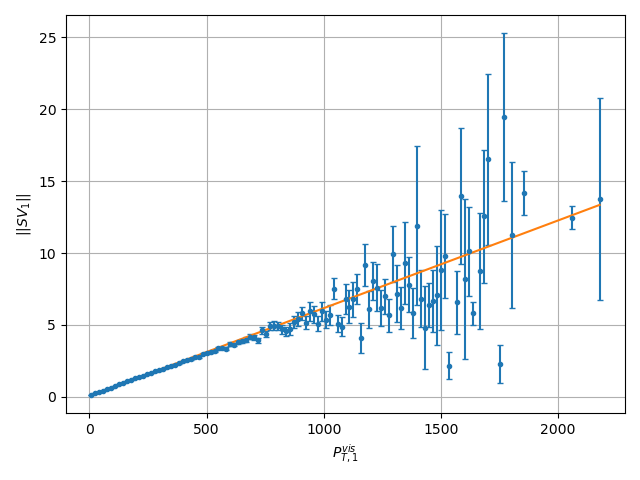

In [50]:
def profileplot(x, y, xlabel, ylabel, bins=100):
    means_result = sps.binned_statistic(x, [y, y**2], bins=bins, statistic='mean')
    means, means2 = means_result.statistic
    standard_deviations = np.sqrt(means2 - means**2)
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    # remove NaNs and single count bins
    nan_idx = np.argwhere(np.isnan(means) ).flatten()
    zero_idx = np.argwhere(standard_deviations == 0)
    to_remove = np.union1d(nan_idx, zero_idx)
    means = np.delete(means, to_remove, None)
    bin_centers = np.delete(bin_centers, to_remove, None)
    standard_deviations = np.delete(standard_deviations, to_remove, None)
    count = Counter(means_result.binnumber)
    to_remove_set = set(to_remove)
    N = []
    for i in range(1,bins+1):
        if i-1 in to_remove_set:
            continue
        if i in count:
            N.append(count[i])
#     print(to_remove.shape)
#     print(bin_centers.shape, means.shape)
    yerr = standard_deviations/np.sqrt(N)
#     yerr = standard_deviations
    # fitting
#     print(bin_centers, means, yerr)
    fit, cov = np.polyfit(bin_centers, means, 1, w=1/yerr, cov=True)
    p = np.poly1d(fit)
    print(f"Fit params: {fit[0]}, {fit[1]}")
    print(f"Diag of cov: {cov[0][0]} , {cov[1][1]}")
    plt.figure()
    plt.errorbar(x=bin_centers, y=means, yerr=yerr, linestyle='none', marker='.', capsize=2)
    plt.plot(bin_centers, p(bin_centers))
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    return fit, cov
    
# profileplot(sv_df['p_t_vis_1'], np.abs(sv_df['sv_x_1']), xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$|SV_1^x|$')
# profileplot(np.abs(sv_df['sv_y_1']), sv_df['p_t_vis_1'], xlabel=r'$|SV_1^y|$', ylabel=r'$P_{T,1}^{vis}$')
# profileplot(np.abs(sv_df['sv_z_1']), sv_df['p_t_vis_1'], xlabel=r'$|SV_1^z|$', ylabel=r'$P_{T,1}^{vis}$')
sv_1 = np.sqrt(sv_df['sv_x_1']**2 + sv_df['sv_y_1']**2 + sv_df['sv_z_1']**2)
profileplot(sv_df['p_t_vis_1'], sv_1, xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$||SV_1||$', bins=150)
plt.savefig('sv_analysis/profile_sv_1.png')
plt.show()

Fit params: 7.587099218549163e-06, -0.00040286099266486936
Diag of cov: 6.095609389861698e-11 , 4.982704010426448e-07


<IPython.core.display.Javascript object>


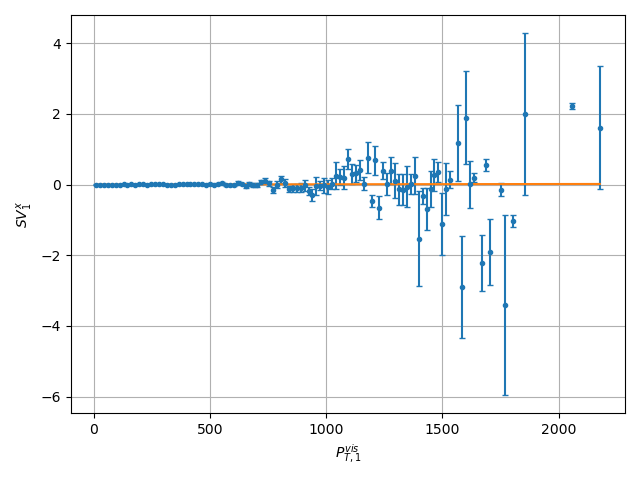

Fit params: 3.996890655543165e-06, -0.00018418355620030612
Diag of cov: 1.4337821280901046e-11 , 1.1724119899869278e-07


<IPython.core.display.Javascript object>


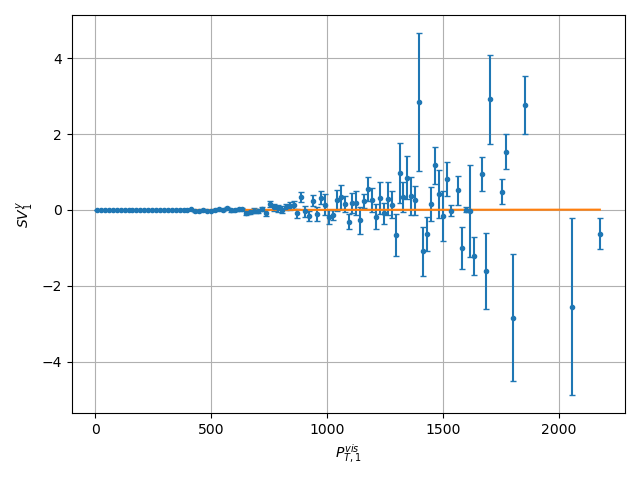

Fit params: -1.1890079423630466e-05, 0.0005733582835278798
Diag of cov: 1.0598831406936434e-10 , 3.284236412214937e-07


<IPython.core.display.Javascript object>


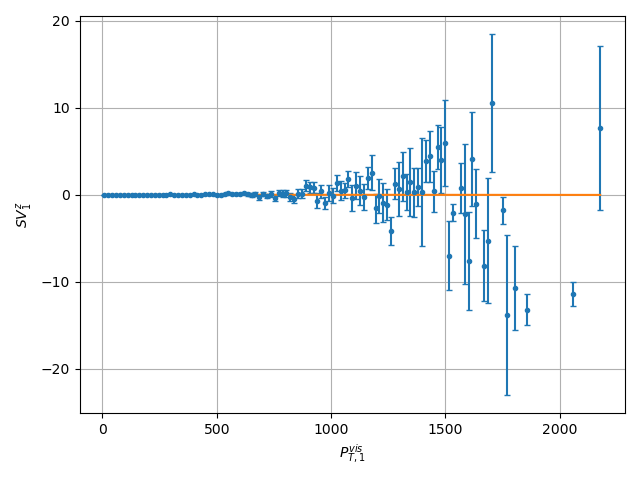

In [56]:
x_fit_1, _ = profileplot(sv_df['p_t_vis_1'], sv_df['sv_x_1'], xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$SV_1^x$', bins=150)
y_fit_1, _ = profileplot(sv_df['p_t_vis_1'], sv_df['sv_y_1'], xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$SV_1^y$', bins=150)
z_fit_1, _ = profileplot(sv_df['p_t_vis_1'], sv_df['sv_z_1'], xlabel=r'$P_{T,1}^{vis}$', ylabel=r'$SV_1^z$', bins=150)
np.savetxt('sv_analysis/sv_fit_1.txt', np.vstack((x_fit_1, y_fit_1, z_fit_1)), delimiter=',')

<IPython.core.display.Javascript object>


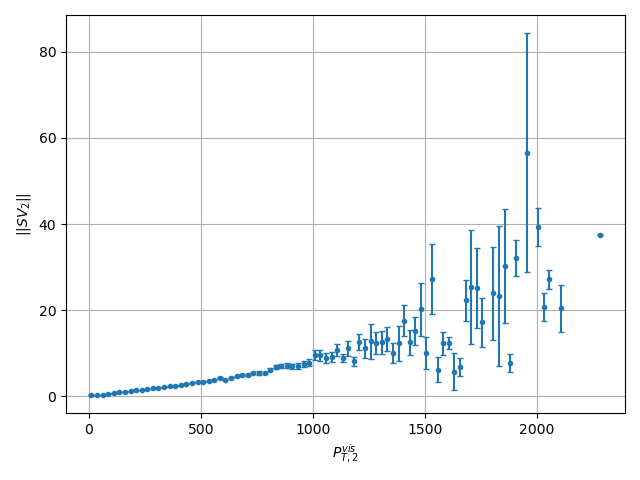

In [156]:
sv_1 = np.sqrt(sv_df['sv_x_2']**2 + sv_df['sv_y_2']**2 + sv_df['sv_z_2']**2)
profileplot(sv_df['p_t_vis_2'], sv_2, xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$||SV_2||$', bins=150)
plt.savefig('sv_analysis/profile_sv_2.png')
plt.show()

Fit params: 2.730899597931602e-06, -0.00022483165297923488
Diag of cov: 1.1980132684826085e-12 , 3.521239695031352e-08


<IPython.core.display.Javascript object>


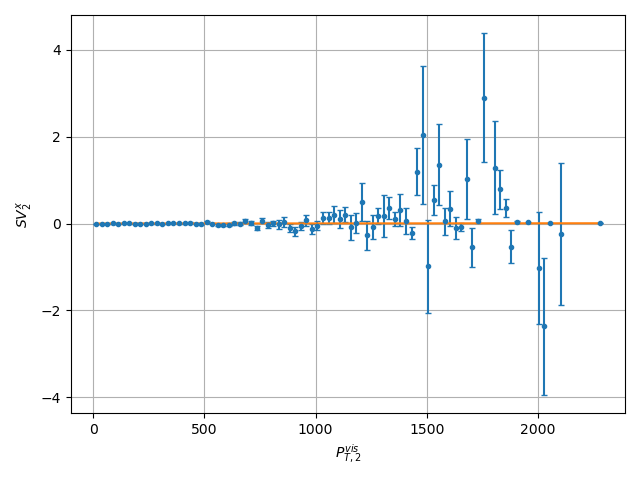

Fit params: 2.752683562930793e-06, -0.000338535697900515
Diag of cov: 5.504333720325587e-12 , 6.546725530153093e-08


<IPython.core.display.Javascript object>


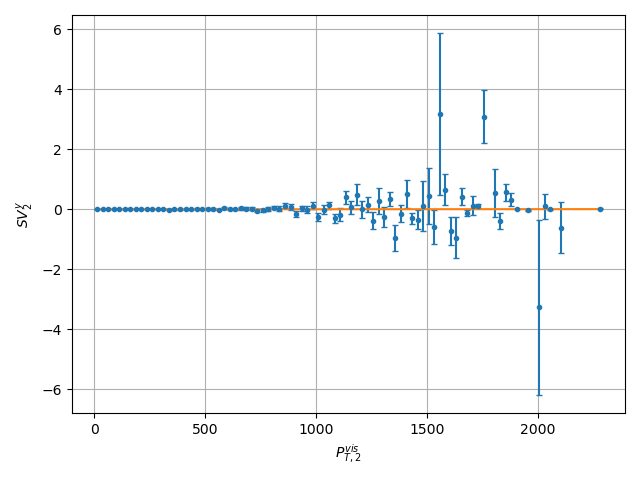

Fit params: -9.087588330109285e-06, 0.0006316360116635827
Diag of cov: 2.59052902280716e-10 , 9.921355098970464e-07


<IPython.core.display.Javascript object>


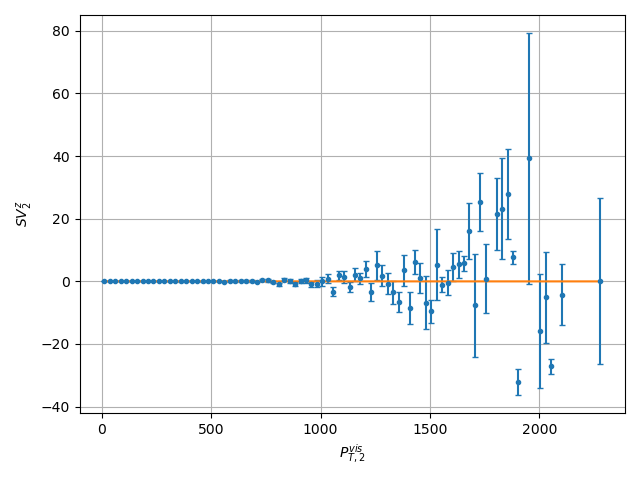

In [57]:
x_fit_2, _ = profileplot(sv_df['p_t_vis_2'], sv_df['sv_x_2'], xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$SV_2^x$', bins=150)
y_fit_2, _ = profileplot(sv_df['p_t_vis_2'], sv_df['sv_y_2'], xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$SV_2^y$', bins=150)
z_fit_2, _ = profileplot(sv_df['p_t_vis_2'], sv_df['sv_z_2'], xlabel=r'$P_{T,2}^{vis}$', ylabel=r'$SV_2^z$', bins=150)
np.savetxt('sv_analysis/sv_fit_2.txt', np.vstack((x_fit_2, y_fit_2, z_fit_2)), delimiter=',')

In [15]:
three_d_scatterplot(sv_df['p_t_vis_1'], sv_df['sv_x_1'], sv_df['sv_y_1'], sv_df['sv_z_1'] )

<IPython.core.display.Javascript object>

In [16]:
three_d_scatterplot(sv_df['p_t_vis_2'], sv_df['sv_x_2'], sv_df['sv_y_2'], sv_df['sv_z_2'] )

<IPython.core.display.Javascript object>

In [ ]:
# pi_1_boosted_rot = np.load('gen_info/pi_1_boosted_rot.npy', allow_pickle=True)
# pi_2_boosted_rot = np.load('gen_info/pi_2_boosted_rot.npy', allow_pickle=True)
# pi0_1_boosted_rot = np.load('gen_info/pi0_1_boosted_rot.npy', allow_pickle=True)
# pi0_2_boosted_rot = np.load('gen_info/pi0_2_boosted_rot.npy', allow_pickle=True)
# rho_1_boosted_rot = pi_1_boosted_rot + pi0_1_boosted_rot
# rho_2_boosted_rot = pi_2_boosted_rot + pi0_2_boosted_rot

to do:  
- [ ] change units - ip is in cm

In [ ]:
l_tau = 87e-4 # in cm
# testing sandbox
for i in range(100):
    vis_dir = rho_1[:,i][1:]/np.linalg.norm(rho_1[:,i][1:])
    ip = ip_1[i]
    delta = vis_dir.dot(ip)**2 - (np.linalg.norm(ip)**2-l_tau**2)
    d_plus = -vis_dir.dot(ip) + delta
    d_minus = -vis_dir.dot(ip) - delta
    # todo: transform d to a point
    if delta > 0:
        sv_1 = d_plus*vis_dir
        sv_2 = d_minus*vis_dir
    else:
        pass